<a href="https://colab.research.google.com/github/Tom-JD/Financial-Sentiment-Analysis-Using-NLP-finbert-/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentimet Analysis of Company Annoucements Trading Strategy**

BERT (Bidirectional Encoder Representations from Transformers) was created in 2018. Briefly, it is a cutting-edge NLP model, released by Jacob Devlin and his team at Google, trained to understand english, as well as numerous other langages. What separates it from earlier models is it has a superior understanding of the context of words, and this is enabled by Transformers (also a very new concept), and its bidirectionality.

BERT can be easily installed, and then trained for a secondary purpose more specific than just "understanding English". Our desired purpose is for BERT to understand the sentiment of a text, specifically a financial text, and to classify sentences or blocks of text as "positive, negative, or neutral". Secondary training of BERT further reduces error for our task at hand, and so is definitely worth the trouble. However, given my rather limited set-up, it would take me weeks just to secondarily train BERT. Luckily, there exists once such trained model, called finbert, found here: https://github.com/ProsusAI/finBERT#:~:text=FinBERT%20is%20a%20pre%2Dtrained,it%20for%20financial%20sentiment%20classification. 

This is no rigorous scientific study, more so just somewhat of an investigation into two things: can we apply NLP to trading a single stock, and is finbert "up-to-scratch".

Initially, I had the intent to apply finbert to financial articles in newspapers (e.g. the financial times) but only paid services go back beyond seven days (a far too short time to backtest over), and of course there are copyright issues that follow... Thus, I decided instead to do this on company announcements, from which it naturally followed I should hone in on a single stock.

The stock I selected is Eurosports Global Ltd, as they have a lot of the rights to the Tokyo 2020 Olympics coverage. On further investigation of Eurosports, I found not only are they listed on the Frankfurt Stock Exchange but also the Singapore Stock Exchange (SGX). I have for a long time been interested in the emerging markets of Asia, and additionally the Olympics is being held in Asia, so thought I would trade this stock over SGX. Perhaps we will see a boom as we approach the Olympics, or perhaps SGX specifically will not care about this.

# Set Up

There is a lot of set up to do, both in terms of libraries and as a result of using Google colab. Below, I import way more libraries than I needed to, but I kept it in to show the wide array of libraries I went through to get the code working.

Of particular interest should be the importing of transformers. BERT is built using transformers (BERT is a stack of tranformer encoders - BERT can be stacked with 12 or 24 encoders, but for most non-professional purposes 12 suffices), so this should come as no surprise.

In [2]:
!pip install -qq transformers
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

     |████████████████████████████████| 2.6 MB 8.8 MB/s 
     |████████████████████████████████| 3.3 MB 55.3 MB/s 
     |████████████████████████████████| 636 kB 58.4 MB/s 
     |████████████████████████████████| 895 kB 80.9 MB/s 


In [ ]:
!pip install huggingface

We mount Google drive to our colab notebook to access all the data I will scrape.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preparing Data

Please refer to the ObtainingStockData.ipynb notebook in the same repository as this for how I scraped the data. All the data is in pdf format, so we have to now scrape the text off the pdfs, and use pdflib to do so.

In [3]:
import glob

In [4]:
!pip install pdflib

     |████████████████████████████████| 5.8 MB 6.4 MB/s 


In [24]:
from pdflib import Document

In [56]:
dir='/content/drive/MyDrive/Colab_Notebooks/Data'

In [57]:
pdfs = glob.glob(glob.escape(dir)+'**/*.pdf', recursive=True)
pdfs[:5]

['/content/drive/MyDrive/Colab_Notebooks/Data/06-May-2021 172314_1.pdf',
 '/content/drive/MyDrive/Colab_Notebooks/Data/06-Aug-2021 232939_1.pdf',
 '/content/drive/MyDrive/Colab_Notebooks/Data/06-Aug-2021 201542_1.pdf',
 '/content/drive/MyDrive/Colab_Notebooks/Data/06-Aug-2021 193354_1.pdf',
 '/content/drive/MyDrive/Colab_Notebooks/Data/05-Aug-2021 234901_1.pdf']

In [58]:
for f in pdfs:
  doc = Document(f)
  for page in doc:
    print(' \n'.join(page.lines).strip())

Streaming output truncated to the last 5000 lines.
C o r P o r aT E 
goVErnanCE rEPorT 
The Company Secretary assists the Chairman in ensuring good information flows within the Board and its Board Committees. 
The Company Secretary attends Board and Board Committee meetings and prepares minutes for all meetings and, where 
appropriate, provides advice, secretarial support and assistance to the Board and ensures adherence to the board procedures 
and relevant rules and regulations applicable to the Company. Under Article 151 of the Articles of Association of the Company, 
the Company Secretary may be appointed and removed by the directors. 
Independent professional advice 
The Board has a process for directors, either individually or as a group, in the furtherance of their duties, to engage independent 
professional advisers, if necessary, at the Group’s expense. 
(b) remuneration matters 
Procedures for Developing remuneration Policies 
Principle 7: There should be a formal and transpa

# Finbert Snetiment Analysis

With the data ready, we will now prepare finbert and use him to perform sentiment analysis on it.

Tokenizers are an important part of anything using Transformers, so we have to import them.

In [59]:
from transformers import BertTokenizer, BertForSequenceClassification

In [60]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [62]:
model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/Colab_Notebooks/finbertProsus/pytorch_model.bin',config='/content/drive/MyDrive/Colab_Notebooks/finbertProsus/config.json',num_labels=3)

As mentioned, we want to classify our sentiment into positve, negative or neutral. Such is common practice in industry (although in academia the norm is to just have positive and negative...this may produce too much volatility in our trading though).

In [63]:
label_list=['positive','negative','neutral']

Now we collect a sentiment value for each document.

In [65]:
sentLs=[]
for f in pdfs:

  doc = Document(f)

  sentSum=0
  for page in doc:
    txt=' \n'.join(page.lines).strip()
    inputs = tokenizer(txt, return_tensors="pt",max_length=512,truncation=True)
    outputs = model(**inputs)
    sent=torch.argmax(outputs[0])
    if sent==0: sentSum+=1
    elif sent==1: sentSum-=1
  
  sentLs.append(sentSum)

In [66]:
assert len(sentLs)==len(pdfs)

In [67]:
df=pd.DataFrame()
df['sent']=sentLs
df['file']=pdfs
df.head()

,sent,file
0,0,/content/drive/MyDrive/Colab_Notebooks/Data/06...
1,0,/content/drive/MyDrive/Colab_Notebooks/Data/06...
2,0,/content/drive/MyDrive/Colab_Notebooks/Data/06...
3,0,/content/drive/MyDrive/Colab_Notebooks/Data/06...
4,0,/content/drive/MyDrive/Colab_Notebooks/Data/05...


In [68]:
import re

In [69]:
dtLs=[]
for f in pdfs:
  dt=re.findall(r'\d{2}-\w{3}-\d{4}',f)[0]
  dtLs.append(dt)

In [71]:
df['date']=dtLs

,sent,file,date
0,0,/content/drive/MyDrive/Colab_Notebooks/Data/06...,06-May-2021
1,0,/content/drive/MyDrive/Colab_Notebooks/Data/06...,06-Aug-2021


In [72]:
df['date']=pd.to_datetime(df['date'])
df.set_index('date',inplace=True)

,sent,file
date,,
2021-05-06,0,/content/drive/MyDrive/Colab_Notebooks/Data/06...
2021-08-06,0,/content/drive/MyDrive/Colab_Notebooks/Data/06...


In [73]:
sent=df.groupby(df.index).sent.sum()
sent.head(2)

date
2014-05-02    0
2014-07-31    0
Name: sent, dtype: int64

In [74]:
sent.sort_values(ascending=False)[:10]

date
2016-07-11    9
2019-07-12    3
2018-07-11    3
2020-11-09    2
2021-08-02    1
2015-07-10    1
2019-07-10    0
2019-04-03    0
2019-01-08    0
2018-09-10    0
Name: sent, dtype: int64

In [ ]:
sent.sort_values(ascending=True)[:10]

Only a very small portion of documents have non-netural net sentiment. This could be because of Eurosports specifically, because we are using company announcements, or because finbert is not yet performing as well as we would like (possibly finbert is better at understanding opinionated articles). More on this at the end.

# Backtesting

With our sentiment data ready, all that is left to do is backtest it.

We are only going to be holding one position at a time for this stock, as specified in the backtrader code below. This means we are not looking for massive returns, thus even a very very small positive return will be somewhat of a success.

In [75]:
!pip install backtrader

     |████████████████████████████████| 410 kB 8.4 MB/s 


We now implement our strategy by modifying the backtester code slightly. Our strategy is simple...if the sentiment is high we buy, and then will conditionally exit our position.

In [159]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt


# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('exitbars', 0),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.datasent = self.datas[0].sent

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.datasent[0] >0:
              # BUY, BUY, BUY!!! (with default parameters)
              self.log('BUY CREATE, %.2f' % self.dataclose[0])

              # Keep track of the created order to avoid a 2nd order
              self.order = self.buy()

        else:

            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + self.params.exitbars):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

In [160]:
dir2='/content/drive/MyDrive/Colab_Notebooks/StockData'

In [161]:

yf=pd.read_csv(dir2+'/5G1.SI.csv')
yf.Date=pd.to_datetime(yf['Date'])
yf.set_index('Date',inplace=True)

comb=yf.merge(sent,left_index=True,right_index=True,how='left').fillna(0)
comb.head(2)

,Open,High,Low,Close,Adj Close,Volume,sent
Date,,,,,,,
2014-01-17,0.35,0.36,0.305,0.315,0.284586,42716000.0,0.0
2014-01-20,0.31,0.31,0.280,0.280,0.252966,6852000.0,0.0


In [162]:
class PandasSent(bt.feeds.PandasData):
  lines=(('sent'),)
  params=(('sent',-1),)

In [163]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    data = PandasSent(dataname=comb)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=100)

    # Set the commission - 0.1% ... divide by 100 to remove the %
    cerebro.broker.setcommission(commission=0.001)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2014-01-17, Close, 0.32
2014-01-20, Close, 0.28
2014-01-21, Close, 0.28
2014-01-22, Close, 0.28
2014-01-23, Close, 0.27
2014-01-24, Close, 0.27
2014-01-27, Close, 0.24
2014-01-28, Close, 0.24
2014-01-29, Close, 0.23
2014-01-30, Close, 0.25
2014-02-03, Close, 0.23
2014-02-04, Close, 0.23
2014-02-05, Close, 0.23
2014-02-06, Close, 0.23
2014-02-07, Close, 0.23
2014-02-10, Close, 0.23
2014-02-11, Close, 0.23
2014-02-12, Close, 0.23
2014-02-13, Close, 0.23
2014-02-14, Close, 0.23
2014-02-17, Close, 0.23
2014-02-18, Close, 0.23
2014-02-19, Close, 0.23
2014-02-20, Close, 0.23
2014-02-21, Close, 0.23
2014-02-24, Close, 0.23
2014-02-25, Close, 0.23
2014-02-26, Close, 0.23
2014-02-27, Close, 0.23
2014-02-28, Close, 0.23
2014-03-03, Close, 0.23
2014-03-04, Close, 0.23
2014-03-05, Close, 0.23
2014-03-06, Close, 0.22
2014-03-07, Close, 0.22
2014-03-10, Close, 0.22
2014-03-11, Close, 0.21
2014-03-12, Close, 0.22
2014-03-13, Close, 0.23
2014-03-14, Close, 0.22
2014

We ended up with positive returns, although admittedly I believe we can improve on these. Let's plot what was going on:

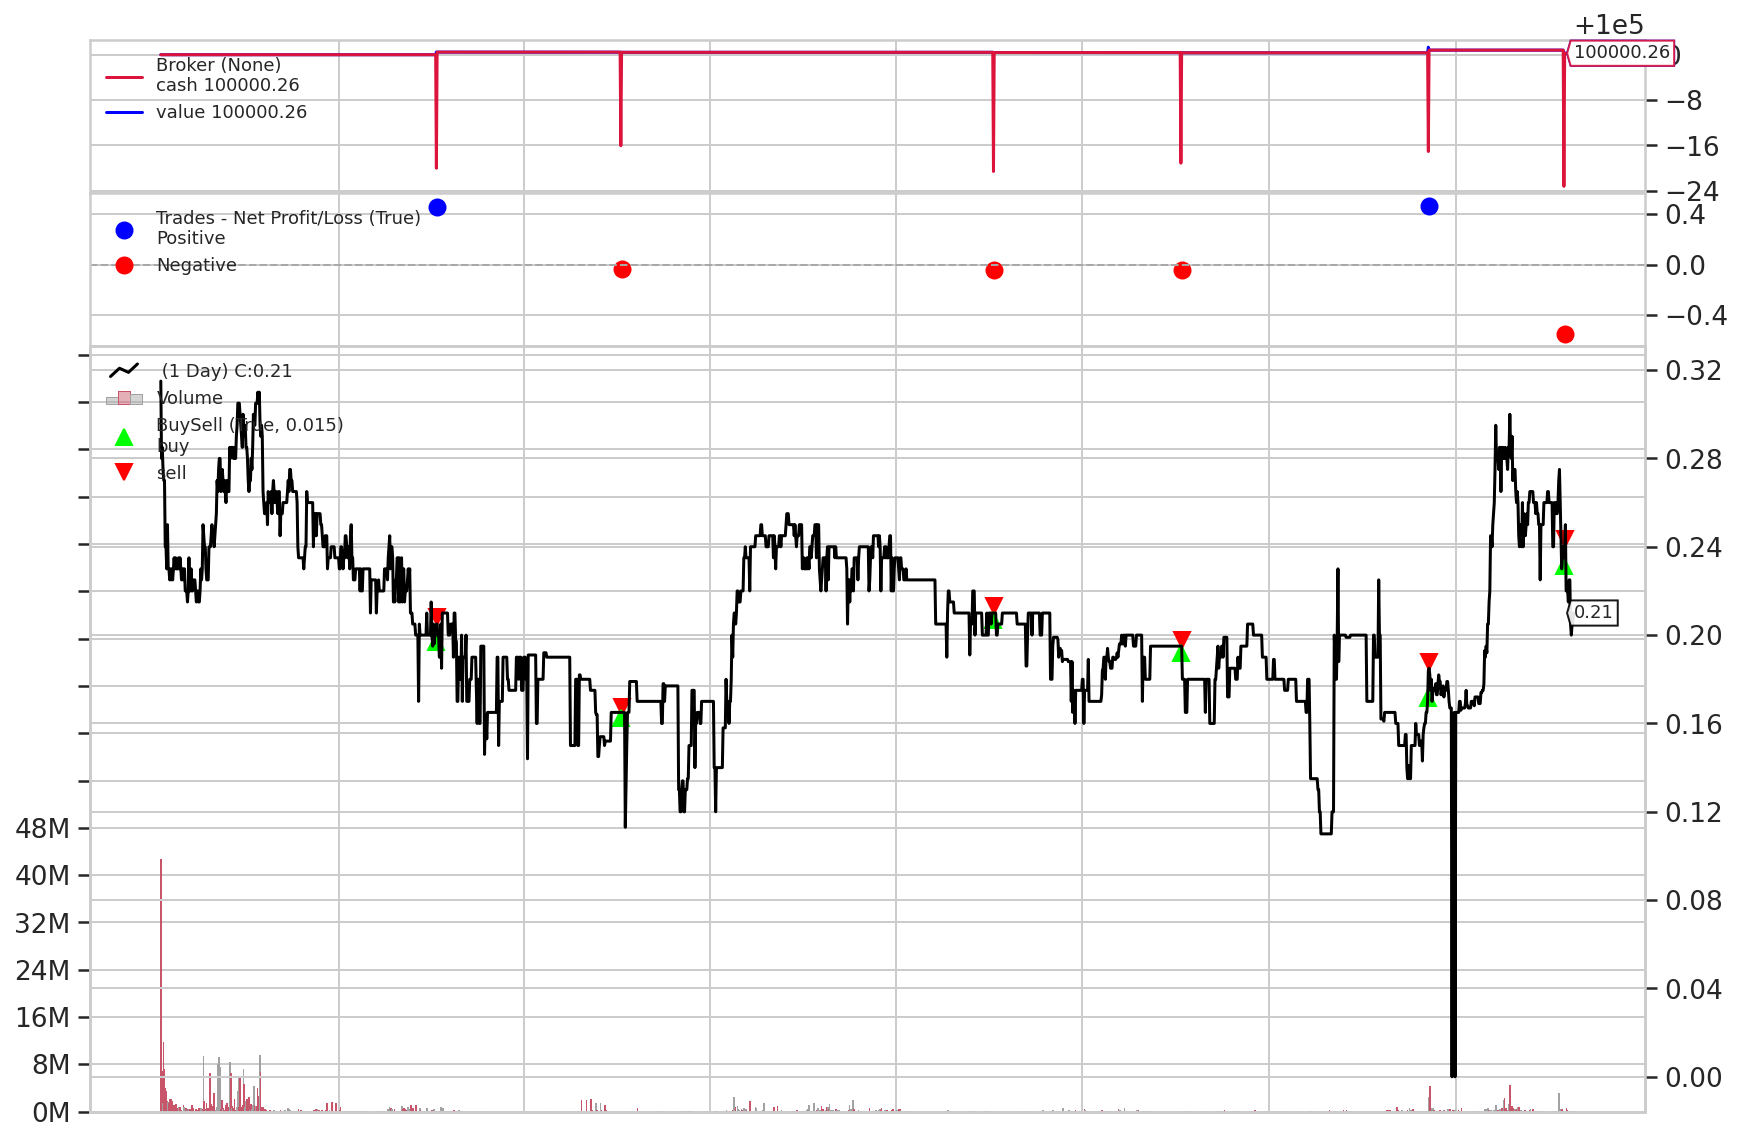

[[<Figure size 864x576 with 4 Axes>]]

In [164]:
cerebro.plot(iplot=False)

In [93]:
sent.sort_values(ascending=False)[:10]

date
2016-07-11    9
2019-07-12    3
2018-07-11    3
2020-11-09    2
2021-08-02    1
2015-07-10    1
2019-07-10    0
2019-04-03    0
2019-01-08    0
2018-09-10    0
Name: sent, dtype: int64

In [94]:
sent.sort_values(ascending=True)[:10]

date
2017-07-12   -9
2016-11-11   -8
2014-11-11   -4
2019-11-11   -4
2020-11-10   -4
2020-07-01   -3
2014-05-02    0
2020-05-06    0
2020-06-11    0
2020-06-12    0
Name: sent, dtype: int64

An interesting observation is the highest sentiment trade (07-11-2016) generated a loss.

Let's mirror this by now shorting the negative sentiments.

In [165]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt


# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('exitbars', 0),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.datasent = self.datas[0].sent

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.datasent[0] <0:
              # BUY, BUY, BUY!!! (with default parameters)
              self.log('SELL CREATE, %.2f' % self.dataclose[0])

              # Keep track of the created order to avoid a 2nd order
              self.order = self.sell()

        else:

            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + self.params.exitbars):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

In [166]:
dir2='/content/drive/MyDrive/Colab_Notebooks/StockData'

In [167]:
yf=pd.read_csv(dir2+'/5G1.SI.csv')
yf.Date=pd.to_datetime(yf['Date'])
yf.set_index('Date',inplace=True)

comb=yf.merge(sent,left_index=True,right_index=True,how='left').fillna(0)
comb.head(2)

,Open,High,Low,Close,Adj Close,Volume,sent
Date,,,,,,,
2014-01-17,0.35,0.36,0.305,0.315,0.284586,42716000.0,0.0
2014-01-20,0.31,0.31,0.280,0.280,0.252966,6852000.0,0.0


In [168]:
class PandasSent(bt.feeds.PandasData):
  lines=(('sent'),)
  params=(('sent',-1),)

In [169]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    data = PandasSent(dataname=comb)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=100)

    # Set the commission - 0.1% ... divide by 100 to remove the %
    cerebro.broker.setcommission(commission=0.001)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2014-01-17, Close, 0.32
2014-01-20, Close, 0.28
2014-01-21, Close, 0.28
2014-01-22, Close, 0.28
2014-01-23, Close, 0.27
2014-01-24, Close, 0.27
2014-01-27, Close, 0.24
2014-01-28, Close, 0.24
2014-01-29, Close, 0.23
2014-01-30, Close, 0.25
2014-02-03, Close, 0.23
2014-02-04, Close, 0.23
2014-02-05, Close, 0.23
2014-02-06, Close, 0.23
2014-02-07, Close, 0.23
2014-02-10, Close, 0.23
2014-02-11, Close, 0.23
2014-02-12, Close, 0.23
2014-02-13, Close, 0.23
2014-02-14, Close, 0.23
2014-02-17, Close, 0.23
2014-02-18, Close, 0.23
2014-02-19, Close, 0.23
2014-02-20, Close, 0.23
2014-02-21, Close, 0.23
2014-02-24, Close, 0.23
2014-02-25, Close, 0.23
2014-02-26, Close, 0.23
2014-02-27, Close, 0.23
2014-02-28, Close, 0.23
2014-03-03, Close, 0.23
2014-03-04, Close, 0.23
2014-03-05, Close, 0.23
2014-03-06, Close, 0.22
2014-03-07, Close, 0.22
2014-03-10, Close, 0.22
2014-03-11, Close, 0.21
2014-03-12, Close, 0.22
2014-03-13, Close, 0.23
2014-03-14, Close, 0.22
2014

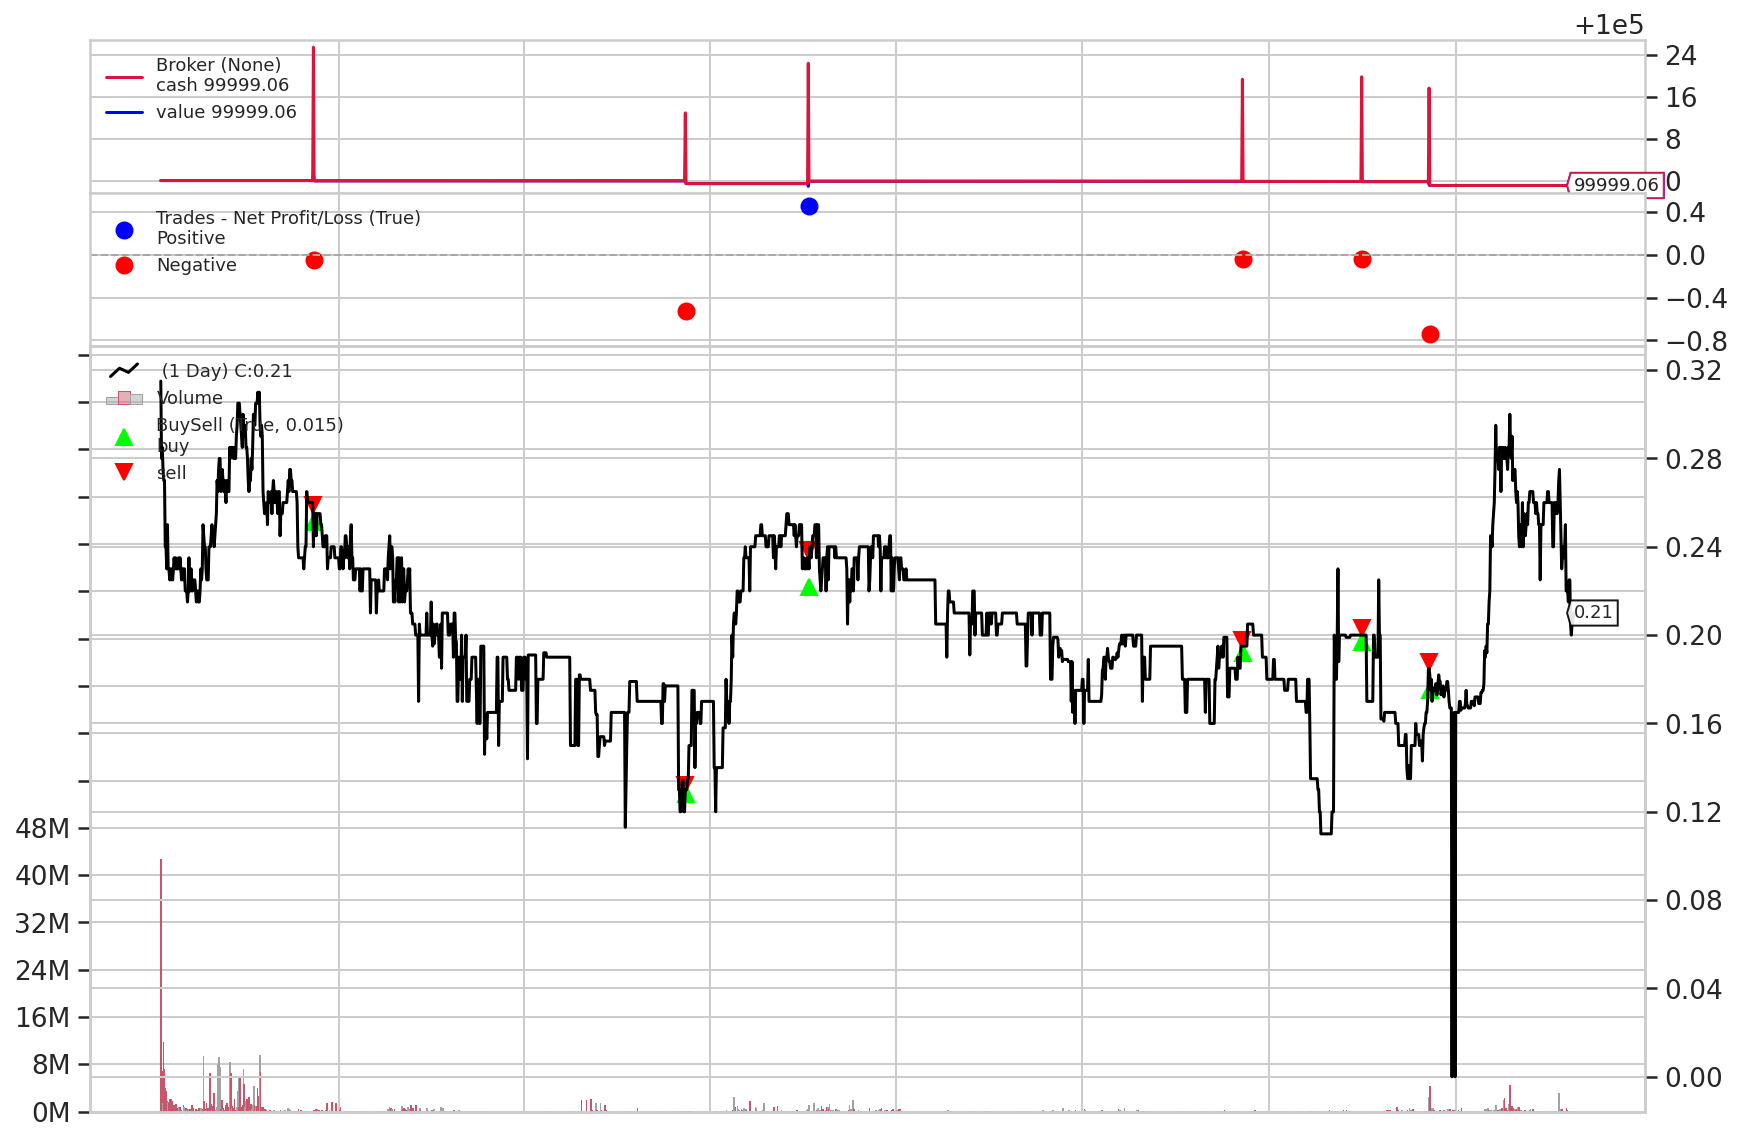

[[<Figure size 864x576 with 4 Axes>]]

In [170]:
cerebro.plot(iplot=False)

In [ ]:
sent.sort_values(ascending=True)[:10]

This strategy generated a loss, so is clearly not optimal. However, it is notoriously difficult to short on the SGX, so I will withold from drawing any conclusions from this.

Again, the larger (in magnitude) sentiments did poorly, but more so than with the longing.

Let's now combine shorting and longing.

In [187]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt


# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('exitbars', 0),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.datasent = self.datas[0].sent

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.datasent[0] >0:
              # BUY, BUY, BUY!!! (with default parameters)
              self.log('BUY CREATE, %.2f' % self.dataclose[0])

              # Keep track of the created order to avoid a 2nd order
              self.order = self.buy()
            elif self.datasent[0] < 0:
              self.log('SELL CREATE, %.2f' % self.dataclose[0])
              self.order = self.sell()

        else:

            # Already in the market ... we might sell
            if self.datasent[0] >0 or self.datasent[0] < 0:
              self.log('EXITED MARKET, %.2f' % self.dataclose[0])
              self.close()

In [188]:
yf=pd.read_csv(dir2+'/5G1.SI.csv')
yf.Date=pd.to_datetime(yf['Date'])
yf.set_index('Date',inplace=True)

comb=yf.merge(sent,left_index=True,right_index=True,how='left').fillna(0)
comb.head(2)

,Open,High,Low,Close,Adj Close,Volume,sent
Date,,,,,,,
2014-01-17,0.35,0.36,0.305,0.315,0.284586,42716000.0,0.0
2014-01-20,0.31,0.31,0.280,0.280,0.252966,6852000.0,0.0


In [189]:
class PandasSent(bt.feeds.PandasData):
  lines=(('sent'),)
  params=(('sent',-1),)

In [190]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    data = PandasSent(dataname=comb)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=100)

    # Set the commission - 0.1% ... divide by 100 to remove the %
    cerebro.broker.setcommission(commission=0.001)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2014-01-17, Close, 0.32
2014-01-20, Close, 0.28
2014-01-21, Close, 0.28
2014-01-22, Close, 0.28
2014-01-23, Close, 0.27
2014-01-24, Close, 0.27
2014-01-27, Close, 0.24
2014-01-28, Close, 0.24
2014-01-29, Close, 0.23
2014-01-30, Close, 0.25
2014-02-03, Close, 0.23
2014-02-04, Close, 0.23
2014-02-05, Close, 0.23
2014-02-06, Close, 0.23
2014-02-07, Close, 0.23
2014-02-10, Close, 0.23
2014-02-11, Close, 0.23
2014-02-12, Close, 0.23
2014-02-13, Close, 0.23
2014-02-14, Close, 0.23
2014-02-17, Close, 0.23
2014-02-18, Close, 0.23
2014-02-19, Close, 0.23
2014-02-20, Close, 0.23
2014-02-21, Close, 0.23
2014-02-24, Close, 0.23
2014-02-25, Close, 0.23
2014-02-26, Close, 0.23
2014-02-27, Close, 0.23
2014-02-28, Close, 0.23
2014-03-03, Close, 0.23
2014-03-04, Close, 0.23
2014-03-05, Close, 0.23
2014-03-06, Close, 0.22
2014-03-07, Close, 0.22
2014-03-10, Close, 0.22
2014-03-11, Close, 0.21
2014-03-12, Close, 0.22
2014-03-13, Close, 0.23
2014-03-14, Close, 0.22
2014

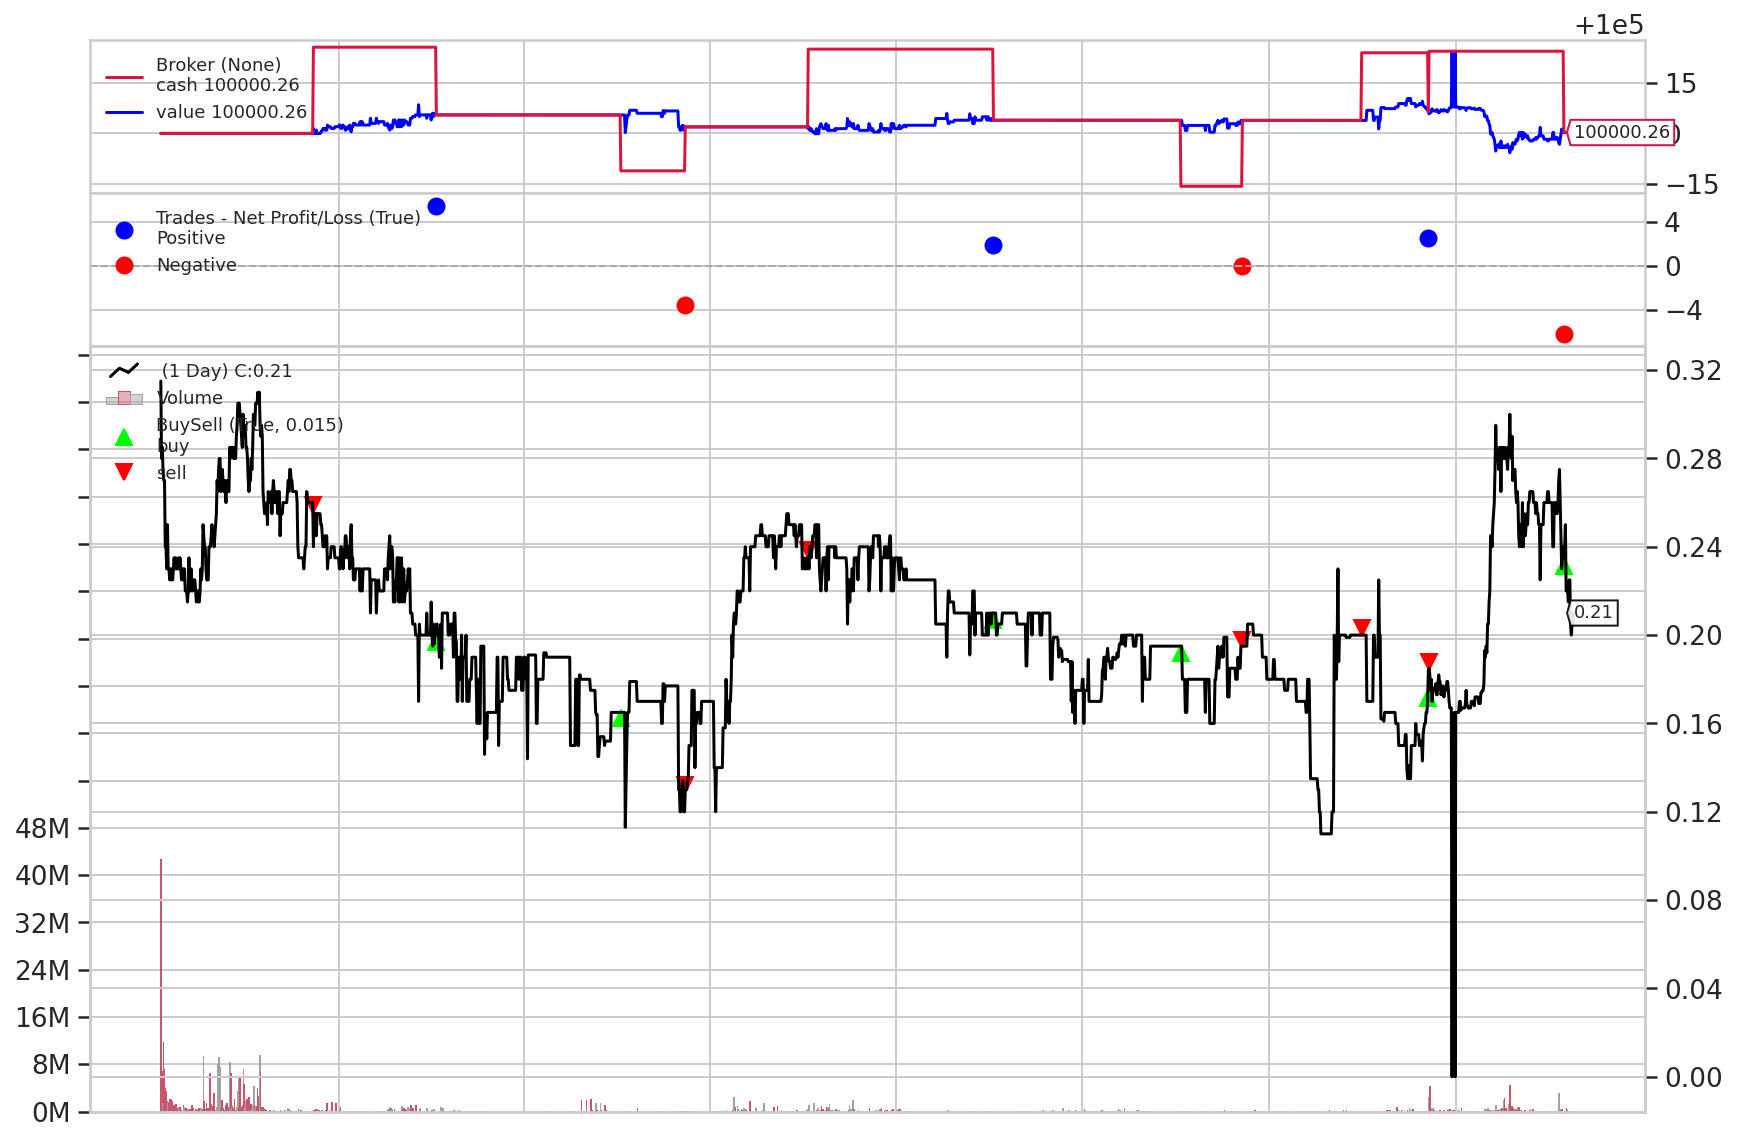

[[<Figure size 864x576 with 4 Axes>]]

In [191]:
cerebro.plot(iplot=False)

We made positive return, exactly as good as the longing (first) strategy. 

As observed, high in magnitude sentimental documents seem to actually be a poor indicator, for both longing and shorting. One such reason is they may be "longer term" documents (e.g. quarterly reports) and thus a less good indicator for that particular moment. Another reason could be such reports have a lot of positive *and* negative statements, so they settle at a number unrepresentative of this tug-of-war sentiment fight. A workaround could be to figure out a proportional sentiment: Total net sentiment // Total non-neutral sentiment.

For now, a quick fix is to simply exclude extreme sentiment numbers, which will constitute the final strategy.

In [192]:
sent.sort_values(ascending=False)[:10]

date
2016-07-11    9
2019-07-12    3
2018-07-11    3
2020-11-09    2
2021-08-02    1
2015-07-10    1
2019-07-10    0
2019-04-03    0
2019-01-08    0
2018-09-10    0
Name: sent, dtype: int64

In [193]:
sent.sort_values(ascending=True)[:10]

date
2017-07-12   -9
2016-11-11   -8
2014-11-11   -4
2019-11-11   -4
2020-11-10   -4
2020-07-01   -3
2014-05-02    0
2020-05-06    0
2020-06-11    0
2020-06-12    0
Name: sent, dtype: int64

In [194]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt


# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('exitbars', 0),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.datasent = self.datas[0].sent

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.datasent[0] >0 and self.datasent[0] <4:
              # BUY, BUY, BUY!!! (with default parameters)
              self.log('BUY CREATE, %.2f' % self.dataclose[0])

              # Keep track of the created order to avoid a 2nd order
              self.order = self.buy()
            elif self.datasent[0] < 0 and self.datasent[0] > -5:
              self.log('SELL CREATE, %.2f' % self.dataclose[0])
              self.order = self.sell()

        else:

            # Already in the market ... we might sell
            if (self.datasent[0] >0 and self.datasent[0] <4) or (self.datasent[0] < 0 and self.datasent[0] > -5):
              self.log('EXITED MARKET, %.2f' % self.dataclose[0])
              self.close()

In [195]:
yf=pd.read_csv(dir2+'/5G1.SI.csv')
yf.Date=pd.to_datetime(yf['Date'])
yf.set_index('Date',inplace=True)

comb=yf.merge(sent,left_index=True,right_index=True,how='left').fillna(0)
comb.head(2)

,Open,High,Low,Close,Adj Close,Volume,sent
Date,,,,,,,
2014-01-17,0.35,0.36,0.305,0.315,0.284586,42716000.0,0.0
2014-01-20,0.31,0.31,0.280,0.280,0.252966,6852000.0,0.0


In [196]:
class PandasSent(bt.feeds.PandasData):
  lines=(('sent'),)
  params=(('sent',-1),)

In [197]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    data = PandasSent(dataname=comb)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=100)

    # Set the commission - 0.1% ... divide by 100 to remove the %
    cerebro.broker.setcommission(commission=0.001)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2014-01-17, Close, 0.32
2014-01-20, Close, 0.28
2014-01-21, Close, 0.28
2014-01-22, Close, 0.28
2014-01-23, Close, 0.27
2014-01-24, Close, 0.27
2014-01-27, Close, 0.24
2014-01-28, Close, 0.24
2014-01-29, Close, 0.23
2014-01-30, Close, 0.25
2014-02-03, Close, 0.23
2014-02-04, Close, 0.23
2014-02-05, Close, 0.23
2014-02-06, Close, 0.23
2014-02-07, Close, 0.23
2014-02-10, Close, 0.23
2014-02-11, Close, 0.23
2014-02-12, Close, 0.23
2014-02-13, Close, 0.23
2014-02-14, Close, 0.23
2014-02-17, Close, 0.23
2014-02-18, Close, 0.23
2014-02-19, Close, 0.23
2014-02-20, Close, 0.23
2014-02-21, Close, 0.23
2014-02-24, Close, 0.23
2014-02-25, Close, 0.23
2014-02-26, Close, 0.23
2014-02-27, Close, 0.23
2014-02-28, Close, 0.23
2014-03-03, Close, 0.23
2014-03-04, Close, 0.23
2014-03-05, Close, 0.23
2014-03-06, Close, 0.22
2014-03-07, Close, 0.22
2014-03-10, Close, 0.22
2014-03-11, Close, 0.21
2014-03-12, Close, 0.22
2014-03-13, Close, 0.23
2014-03-14, Close, 0.22
2014

This is much better. We could go one step further, and actually long on extremely negative sentiments and short on extremely positive sentiments, but there is no logical reason to do so, and so that would be overfitting as it is a decision based purely on the data I have at hand.

That concludes this project (post-project I tesed with more companies and got slightly more exciting results although completed no official write up for them). 

Some final notes:


*   I believe that the lack of PDFs with a non-neutral sentiment is the main cause for a fairly unexciting project. And for this, I believe there are two primary causes. Firstly, I used company announcements rather than actual opinionated articles (such as from Newspapers). As stated above, I was forced to do this in order to be able to backtest beyond 7 days via an open source. Secondly, I believe finbert (and other sentiment-trained BERT models) still have a long way to go until they can truly guage sentiment on the level of humans, though I am optimistic this will be achieved in the coming years, given how rapidly we have already reached an NLP model as sophisticated as BERT.
*   I will possibly in the future attempt this but for mutliple stocks at once to build up a diverse portfolio. I would have much more faith in that showing good returns. Although the caveat of extreme sentiments (in either direction) requires further investigation. Perhaps this issue is specific to company announcements (e.g. focusing on Newspaper articles may eliminate it), perhaps a failure on the part of finbert, or perhaps it is a legitimate issue. Nonetheless, I am sure my next investigation will put this to rest.
*   Later note: Tested code with other companies, and saw more response (one company returned finap portfolio value of 100052.20 over half a year!). Perhaps then this initial example was just unlucky in that it had very little within the company announcements that finbert could extract a non-neutral sentiment out of.

